# Deep Q Learning to Play Space Invaders

In [1]:
# Import packages
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
import time

from tensorflow.keras.models import Sequential
import tensorflow as tf
print(tf.__version__)

from skimage import transform 
from skimage.color import rgb2gray 

1.15.0


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3289490800645379675
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Create the environment

In [4]:
# Create our environment
env = gym.make("SpaceInvaders-v0")

# Get state and action space
state_size = env.observation_space
action_size = env.action_space.n

print("The size of our frame is: ", state_size)
print("The action size is : ", action_size)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


## Preprocess Functions

In [5]:
# plotting the images in a list
def plot_frames(display_list, title_list = None):
    
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        
        if title_list:
            plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

### Image Filtering

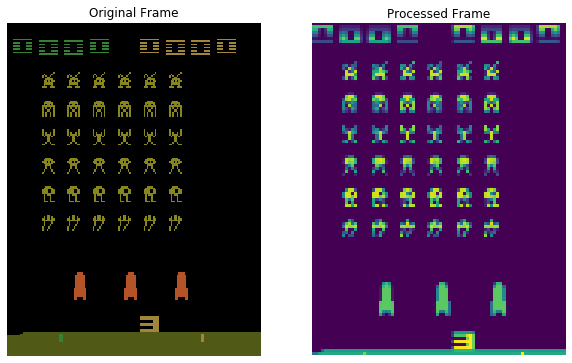

Size before process:  (210, 160, 3)
Size after process:  (110, 84)


In [6]:
# Normalise, turn into greyscale and crop image
frame_size = (110, 84)
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, frame_size)
    
    return preprocessed_frame # 110x84x1 frame

# Test out the preprocess procedure
sample_state = env.reset()
sample_state_processed = preprocess_frame(sample_state)
plot_frames([sample_state, sample_state_processed], ['Original Frame','Processed Frame'])

print('Size before process: ', sample_state.shape)
print('Size after process: ', sample_state_processed.shape)

### Stack the frames

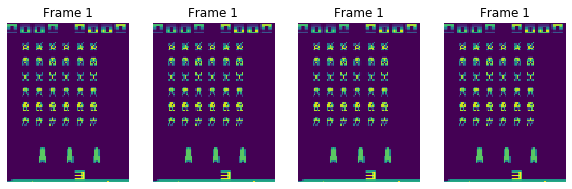

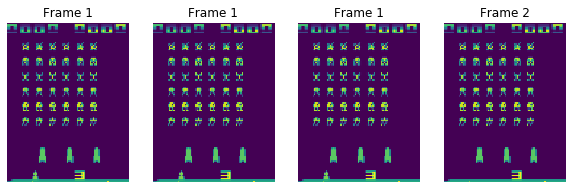

In [7]:
# Given a stacked frame, append a new frame to this stack
def stack_frames(stacked_frames, new_frame, is_new_episode):
    
    # Preprocess frame before stacking
    frame = preprocess_frame(new_frame)
    
    # if new episode make copies of frame, else append frame
    if is_new_episode:
        
        # Clear stacked frames
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        
        # Append the same frame to the stack stack_size times
        for _ in range(0, stack_size):
            stacked_frames.append(frame)
        
        # Return a numpy array for the stacked frame
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    return stacked_states, stacked_frames

# Stacking frames to provide input = [frame 1, frame 2, frame 3, frame 4]
stack_size = 4

# Initialise with array of zeros
stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)

# Test out the stack_frames procedure
sample_state = env.reset()
stacked_states, stacked_frames = stack_frames(stacked_frames, sample_state, True)
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(0,4)])

for i in range(0, 4):
    sample_next_state, _ , done , _  = env.step(env.action_space.sample())
    stacked_states, stacked_frames = stack_frames(stacked_frames, sample_next_state, False)
    
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(1,4)] + ['Frame 2'] )

## Training 

In [18]:
# Define paramters for training 
LEARNING_RATE = 0.001
MEMORY_SIZE = 30000
INITIAL_MEMORY_SIZE = 10000
BATCH_SIZE = 64
MAX_STEP = 50000
UPDATE_MODEL_STEP = 10000
TRAINING_FREQUENCY = 4
LOG_FREQUENCY = TRAINING_FREQUENCY*5

EXPLORATION_RATE = 1
EXPLORATION_DECAY = 0.9999
EXPLORATION_MIN = 0.01

GAMMA = 0.9

### Create Deep Q Neural Network

In [9]:
class DQNetworks:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            self.mean_target = tf.reduce_mean(self.target_Q)
            
            # Input the Importance sampling weights here
            self.IS_weights = tf.placeholder(tf.float32, [None], name="IS_weights")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 110x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            with tf.variable_scope('conv1', reuse=True):
                self.conv1w = tf.get_variable('kernel')
                self.conv1b = tf.get_variable('bias')
                
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")

                
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
            
            with tf.variable_scope('conv2', reuse=True):
                self.conv2w = tf.get_variable('kernel')
                self.conv2b = tf.get_variable('bias')
                

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 64,
                                 kernel_size = [3,3],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
            
            with tf.variable_scope('conv3', reuse=True):
                self.conv3w = tf.get_variable('kernel')
                self.conv3b = tf.get_variable('bias')

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            ## Here to separate into two streams
            # The one to calculate V(s)
            self.value_fc = tf.layers.dense(inputs = self.flatten,
                                            units = 512,
                                            activation = tf.nn.elu,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name="value_fc")
            
            with tf.variable_scope('value_fc', reuse=True):
                self.value_fcw = tf.get_variable('kernel')
                self.value_fcb = tf.get_variable('bias')
                
            self.value =  tf.layers.dense(inputs = self.value_fc,
                                          units = 1,
                                          activation = None,
                                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          name="value")
            
            # The one to calculate A(s,a)
            self.advantage_fc = tf.layers.dense(inputs = self.flatten,
                                                units = 512,
                                                activation = tf.nn.elu,
                                                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                                name="advantage_fc")
            
            with tf.variable_scope('advantage_fc', reuse=True):
                self.advantage_fcw = tf.get_variable('kernel')
                self.advantage_fcb = tf.get_variable('bias')
            
            self.advantage = tf.layers.dense(inputs = self.advantage_fc, 
                                             kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                             units = self.action_size, 
                                             activation=None,
                                             name = "advantage")
            
            
            # Agregating layer 
            self.output = tf.add(self.value, tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True)))
            
            self.max_Q_pred = tf.reduce_max(self.output, axis = 1)
            self.max_Q_mean_pred = tf.reduce_mean(self.max_Q_pred)
            self.argmax_Q_pred = tf.argmax(self.output, axis = 1)
            
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis = -1)      
        
            
            # Absolute errors for Priortising
            self.abs_TD_error = tf.abs(self.target_Q - self.Q)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(self.IS_weights * tf.square(self.abs_TD_error))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [10]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "DQN")
TargetDQNetwork = DQNetworks([110, 84, 4], action_size, LEARNING_RATE, "TargetDQN")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# Setup TensorBoard Writer
!rm -rf ./tensorboard/dddqn/1
writer = tf.summary.FileWriter("./tensorboard/dddqn/1")

tf.summary.scalar("Loss", DQNetwork.loss)
tf.summary.scalar("Mean_Target", DQNetwork.mean_target)
tf.summary.scalar("Mean_Predict", DQNetwork.max_Q_mean_pred)
tf.summary.histogram("Conv1/Weights", DQNetwork.conv1w)
tf.summary.histogram("Conv1/Bias", DQNetwork.conv1b)
tf.summary.histogram("Conv1/Activation", DQNetwork.conv1_out)
tf.summary.histogram("Conv2/Weights", DQNetwork.conv2w)
tf.summary.histogram("Conv2/Bias", DQNetwork.conv2b)
tf.summary.histogram("Conv2/Activation", DQNetwork.conv2_out)
tf.summary.histogram("Conv3/Weights", DQNetwork.conv3w)
tf.summary.histogram("Conv3/Bias", DQNetwork.conv3b)
tf.summary.histogram("Conv3/Activation", DQNetwork.conv3_out)
tf.summary.histogram("Value/Weights", DQNetwork.value_fcw)
tf.summary.histogram("Value/Bias", DQNetwork.value_fcb)
tf.summary.histogram("Advantage/Weights", DQNetwork.advantage_fcw)
tf.summary.histogram("Advantage/Bias", DQNetwork.advantage_fcb)
tf.summary.histogram("Q_values/Q_predict", DQNetwork.output)
tf.summary.histogram("Q_values/Q_target", DQNetwork.target_Q)
tf.summary.histogram("Q_values/Q_predict_max", DQNetwork.max_Q_pred)
tf.summary.histogram("Q_values/arg_Q_predict_max", DQNetwork.argmax_Q_pred)

## Losses
write_op = tf.summary.merge_all()

In [12]:
# Update the target network 
def update_graph():
    # Get weights
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQN")
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetDQN")
    # Update the target 
    updated_weights = [to_var.assign(from_var) for from_var, to_var in zip(from_vars, to_vars)]
    return updated_weights

### Create memory for experience relay

In [13]:
class SumTree:
    
    # Index for pointing to data 
    data_index = 0
    capacity_filled = 0
    
    # Initialise the tree and data
    def __init__(self, capacity):
        
        # The size of the leaves
        self.capacity = capacity
        
        # Define the tree list itself, zeros everywhere
        self.tree = np.zeros(capacity*2 - 1)
        
        # Define the data list for holding experiences, zeros everywhere
        self.data = np.zeros(capacity, dtype=object)
        
    # Add new values to tree
    def add(self, priority, data):
        
        # add to data list 
        self.data[self.data_index] = data
        
        # add the priority to the leaf of the tree
        tree_index = self.data_index + self.capacity - 1
        self.update(priority, tree_index)
        
        # Increase data_index
        self.data_index += 1
        if self.data_index > self.capacity - 1:
            self.data_index = 0
            
        # Inrease capacity filled
        if self.capacity_filled < self.capacity:
            self.capacity_filled += 1
            
    # Update all the nodes leading up to a leaf
    def update(self, priority, tree_index):
        
        # Find the change in priority value
        delta_priority = priority - self.tree[tree_index]
        
        # Update leaf
        self.tree[tree_index] = priority
        
        # Propagate change up
        while tree_index != 0 :
            tree_index = (tree_index - 1)//2
            self.tree[tree_index] += delta_priority 
            
    # sample a leaf from a value
    def get_leaf(self, value):
        
        # Define initial indixes
        parent_index = 0
        left_index = 1
        right_index = 2
        
        # Retrive the leaf algorithm
        while left_index < (2*self.capacity - 1):
            if self.tree[left_index] >= value: 
                parent_index = left_index
            else:
                parent_index = right_index
                value = value - self.tree[left_index]      
            # Update left_index for next iteration
            left_index = parent_index*2 + 1
            right_index = left_index + 1
            
        return parent_index, self.tree[parent_index], self.data[parent_index + 1 - self.capacity]

In [14]:
class Memory():
    
    # Max TD error
    abs_error_upper = 1.0;
    
    # Prioritzation exponents
    PER_a = 0.6
    PER_b = 0.4
    epsilon= 0.01
    
    # Incremental value for PER_b
    PER_b_increments = 0.001
    
    def __init__(self, capacity):
        
        # Create the sum tree
        self.memory_tree = SumTree(capacity)
            
    def store(self, experience):
        
        # Get the max priority so far
        max_priority = np.max(self.memory_tree.tree[-self.memory_tree.capacity:])
        
        # if max prioity is 0 then set it as abs_error_upper
        if max_priority == 0:
            max_priority = self.abs_error_upper
        
        # Store this experience in the tree
        self.memory_tree.add(max_priority, experience)
        
        
    def sample(self, n):
        
        # Get total priority
        total_priority = self.memory_tree.tree[0]
        
        # Sample from a mini range [0:total_priority] in batch sizes
        sample_ranges = np.linspace(0, total_priority, num=n+1)
        
        # get min P(i) of data filled so far and max weight to scale maximum weights = 1
        start_filled = -self.memory_tree.capacity
        end_filled = -(self.memory_tree.capacity - self.memory_tree.capacity_filled)
        if  end_filled == 0:
            min_probability = np.min(self.memory_tree.tree[start_filled:])/total_priority
        else:
            min_probability = np.min(self.memory_tree.tree[start_filled:end_filled])/total_priority
        max_weight = (self.memory_tree.capacity_filled * min_probability) ** (-self.PER_b)
        
        # Initialise list for storing
        tree_indexes = np.empty(n, dtype=np.int32)
        IS_weights = np.empty(n, dtype=np.float32)
        batch = []
        
        # Sample in a loop
        for i in range(0, n):
            value = np.random.uniform(sample_ranges[i], sample_ranges[i+1])
            tree_index, priority, experience = self.memory_tree.get_leaf(value)
            
            # Append tree indicies of sample 
            tree_indexes[i] = tree_index
            
            # Obtain IS_weights
            sample_probability = (priority / total_priority)
            IS_weights[i] = ((self.memory_tree.capacity_filled * sample_probability) ** (-self.PER_b)) / max_weight
            
            # append expereice  to batch
            batch.append(experience)
            
        # Increase PER_b value for every sampling action max = 1
        if self.PER_b < 1.0:
            self.PER_b += self.PER_b_increments
        
        return tree_indexes, IS_weights, batch
            
            
    def update_batch(self, tree_indexes, TD_errors):
        priorities = np.minimum(self.abs_error_upper, (TD_errors + self.epsilon)) ** self.PER_a
        
        # update the batch of prrioties
        for idx, new_p in zip(tree_indexes, priorities):
            self.memory_tree.update(new_p, idx)

### Predict Actiopm to exploit or explore

In [15]:
# Function to pick action either from model or take random action
def act(state, exploration_rate):
    
    # Take random action
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    
    # Else use the model to predict a action
    q_values = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state[tf.newaxis,...]})
    
    return np.argmax(q_values[0])

### Train agent in batches from memory

In [16]:
# Function to fit data from experience obtained from memory, THE LEARNING PROCEDURE
def train_model(BATCH_SIZE, total_steps):
    
    # Sample from memory
    tree_idx, IS_weights, batch = memory.sample(BATCH_SIZE)
    
    # Extract each parameter from batch
    states_mb = np.zeros((BATCH_SIZE, 110, 84, 4))
    actions_mb = np.zeros([BATCH_SIZE, action_size], dtype = int)
    rewards_mb = np.zeros(BATCH_SIZE)
    next_states_mb = np.zeros((BATCH_SIZE, 110, 84, 4))
    dones_mb = np.zeros(BATCH_SIZE)
    for i in range(0,len(batch)):
        states_mb[i] = batch[i][0]
        actions_mb[i][batch[i][1]] = 1
        rewards_mb[i] = batch[i][2]
        next_states_mb[i] = batch[i][3]
        dones_mb[i] = batch[i][4]

    targets_mb = np.zeros(BATCH_SIZE)

    # Model predict the Q-values
    q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
    q_target_next_state = sess.run(TargetDQNetwork.output, feed_dict = {TargetDQNetwork.inputs_: next_states_mb})

    # Calculate target Q 
    for i in range(0, len(batch)):
        terminal = dones_mb[i]
        if terminal:
            targets_mb[i] = rewards_mb[i]
        else:
            action = np.argmax(q_next_state[i])
            targets_mb[i] = rewards_mb[i] + GAMMA * q_target_next_state[i][action]

    # Fit the data 
    _, loss, absolute_errors = sess.run([DQNetwork.optimizer, DQNetwork.loss, DQNetwork.abs_TD_error],
                        feed_dict={DQNetwork.inputs_: states_mb,
                                   DQNetwork.target_Q: targets_mb,
                                   DQNetwork.actions_: actions_mb,
                                  DQNetwork.IS_weights: IS_weights})

    
    # Update the priorites with latest TD errors
    memory.update_batch(tree_idx, absolute_errors)
    
    # Write TF Summaries
    if total_steps % LOG_FREQUENCY == 0:
        summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                        DQNetwork.target_Q: targets_mb,
                                                        DQNetwork.actions_: actions_mb,
                                                        DQNetwork.IS_weights: IS_weights})
        writer.add_summary(summary, total_steps)
        writer.flush()

    return loss

### Test agent by taking random actions

In [17]:
# Play a game to test environment 
def test(n_episodes, model = None, memory = None, render=False, clip_reward=True):
    
    # Initialise average rewards
    avg_rewards = 0
    run_list = []
    
    for i in range(1, n_episodes+1):
        
        # Initialise the start of environment
        state = env.reset()
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        done = False 
        total_reward = 0
        steps = 0
        
        # Play the environment until done
        while not done:
            if render:
                env.render()
                time.sleep(0.01)
            if model:
                action = np.argmax(sess.run(model.output, feed_dict = {model.inputs_: state[tf.newaxis,...]})[0])
            else:
                action = np.random.randint(action_size)
            state_next, reward, done, info = env.step(action)
            if clip_reward:
                reward = np.sign(reward)
            if done:
                state_next = np.zeros((110,84), dtype=np.int)
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)
            if memory:
                memory.store((state, action, reward, state_next, done))
            state = state_next
            total_reward += reward
            steps += 1
            if steps > MAX_STEP:
                done = True
                
        if render:
            env.close()
        
        # Store running average and run results
        avg_rewards = avg_rewards + 1/(i) * (total_reward - avg_rewards)
        run_list.append(steps)
        
    print("The average rewards for {} runs is {}".format(n_episodes, avg_rewards))
        
    return run_list, avg_rewards

### Training Procedure

In [19]:
# Initialise memory for training
memory = Memory(MEMORY_SIZE)

# Run Tests and store initial memory
print("Start filling memory")
while memory.memory_tree.capacity_filled  < INITIAL_MEMORY_SIZE:
    steps, total_reward = test(1, model = None, memory = memory)

print("Memory filled! The memory length is", memory.memory_tree.capacity_filled)

Start filling memory


C:\Users\MY2\AppData\Local\Continuum\anaconda3\envs\tf14\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


The average rewards for 1 runs is 5.0
The average rewards for 1 runs is 12.0
The average rewards for 1 runs is 7.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 4.0
The average rewards for 1 runs is 10.0
The average rewards for 1 runs is 24.0
The average rewards for 1 runs is 8.0
The average rewards for 1 runs is 9.0
The average rewards for 1 runs is 9.0
The average rewards for 1 runs is 11.0
The average rewards for 1 runs is 7.0
Memory filled! The memory length is 10441


In [20]:
# Start the session
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())   
sess.run(update_graph())
print("Target network updated!")

Target network updated!


In [21]:
# Store measurements
losses = []
reward_list = []
step_list = []
total_steps = 0
max_reward = 0
start_time = time.time()

total_episodes = 2000
for episode in range(total_episodes):
    
    # Set step to 0
    step = 0
    episode_rewards = 0
    done = False
    
    # Make a new episode and observe the first state
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)

    while not done:
        step += 1
        total_steps += 1

        # With ϵ select a random action atat, otherwise select a = argmaxQ(st,a)
        action = act(state, EXPLORATION_RATE)

        # Do the action
        next_state, reward, done, _ = env.step(action)
        reward = np.sign(reward)

        # Add the reward to total reward
        episode_rewards += reward

        # If the game is finished
        if done:
            # the episode ends so no next state
            next_state = np.zeros((110,84), dtype=np.int)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

            # print information at the end of the episode
            print("Episode {}, exploration rate: {:.4f}, final rewards: {}, final loss is {:.4f}, Time elapsed: {:.4f}"\
                  .format(episode+1, EXPLORATION_RATE, episode_rewards, loss, time.time() - start_time))
            start_time = time.time()
            
            test(1, model=DQNetwork, render=False, clip_reward=False)
            
            # Add experience to memory
            experience = state, action, reward, next_state, done
            memory.store(experience)
            
            # Append values at the end of an episode
            reward_list.append(episode_rewards)
            
            # Save model with best reward
            if episode_rewards > max_reward:
                path = r"C:\Users\MY2\iCloudDrive\Documents\Computer Science\Reinforcement Learning\Model Results\Atari Space Invader\best model\model.ckpt"
                save_path = saver.save(sess, path)
                print("Best model saved")
                max_reward = episode_rewards

        else:

            # Stack the frame of the next_state
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

            # Add experience to memory
            experience = state, action, reward, next_state, done
            memory.store(experience)

            # st+1 is now our current state
            state = next_state

        ### LEARNING PART  
        if total_steps % TRAINING_FREQUENCY == 0:
            loss = train_model(BATCH_SIZE, total_steps)
            losses.append(loss)
            EXPLORATION_RATE *= EXPLORATION_DECAY
            EXPLORATION_RATE = max(EXPLORATION_MIN, EXPLORATION_RATE)
            
        if total_steps % UPDATE_MODEL_STEP ==0:
            # Update the parameters of our TargetNetwork with DQN_weights
            update_target = update_graph()
            sess.run(update_target)
            path = r"C:\Users\MY2\iCloudDrive\Documents\Computer Science\Reinforcement Learning\Model Results\Atari Space Invader\model 3\model.ckpt"
            save_path = saver.save(sess, path)
            print("Model updated and saved")

C:\Users\MY2\AppData\Local\Continuum\anaconda3\envs\tf14\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


Episode 1, exploration rate: 0.9860, final rewards: 7.0, final loss is 0.0069, Time elapsed: 23.5842
The average rewards for 1 runs is 0.0
Best model saved
Episode 2, exploration rate: 0.9682, final rewards: 8.0, final loss is 0.0105, Time elapsed: 39.9425
The average rewards for 1 runs is 270.0
Best model saved
Episode 3, exploration rate: 0.9512, final rewards: 11.0, final loss is 0.0090, Time elapsed: 41.5062
The average rewards for 1 runs is 120.0
Best model saved
Episode 4, exploration rate: 0.9338, final rewards: 11.0, final loss is 0.0060, Time elapsed: 43.8542
The average rewards for 1 runs is 460.0
Episode 5, exploration rate: 0.9219, final rewards: 7.0, final loss is 0.0078, Time elapsed: 38.3127
The average rewards for 1 runs is 0.0
Episode 6, exploration rate: 0.9107, final rewards: 5.0, final loss is 0.0069, Time elapsed: 30.5399
The average rewards for 1 runs is 75.0
Episode 7, exploration rate: 0.8980, final rewards: 8.0, final loss is 0.0077, Time elapsed: 32.1395
The a

KeyboardInterrupt: 

In [26]:
test(10, model=DQNetwork, render=False, clip_reward=False)

The average rewards for 10 runs is 125.0


([518, 786, 540, 547, 529, 666, 681, 643, 528, 789], 125.0)

Text(0.5, 0, 'Runs')

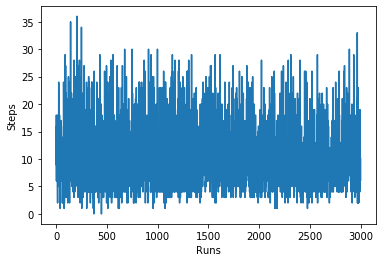

In [23]:
# plot result
plt.plot(reward_list)
plt.ylabel('Rewards')
plt.xlabel('Episodes')

Text(0.5, 0, 'Runs')

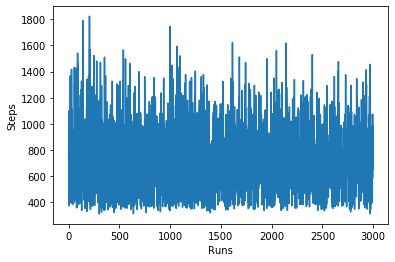

In [24]:
plt.plot(step_list)
plt.ylabel('Steps')
plt.xlabel('Runs')

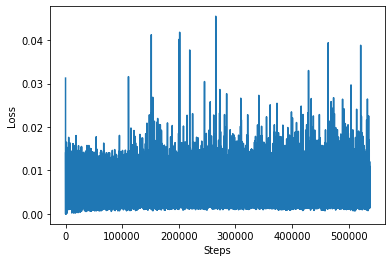

In [25]:
# plot loss
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()